#**Imports**#

In [1]:
!pip install jsonlines

In [2]:
#test device
import tensorflow as tf
tf.test.gpu_device_name()

''

In [3]:
import jsonlines

import pandas as pd
import numpy as np

from typing import Tuple, List, Dict, Optional
from collections import Counter, defaultdict

from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD, Adam, RMSprop

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt


import os

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import string
import re

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [5]:
!rm -rf sample_data
!mkdir data

In [6]:
%cd data

/content/data


In [7]:
#directory to save checkpoints and path to it
root_folder = '/content/data/' 
!mkdir output_folder
PATH_OUTPUT_FOLDER = os.path.join(root_folder, 'output_folder/')

In [9]:
#get data
!git clone https://github.com/SapienzaNLP/nlp2021-hw1/

Cloning into 'nlp2021-hw1'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 40 (delta 11), reused 18 (delta 0), pack-reused 0
Unpacking objects: 100% (40/40), done.


In [10]:
#datasets
train_path = 'nlp2021-hw1/data/train.jsonl'
dev_path = 'nlp2021-hw1/data/dev.jsonl'

In [11]:
#borrowed from evaluation.py function to read datasets the same format as during testing
def read_dataset(path: str) -> Tuple[List[Dict], List[str]]:

    sentence_pairs = []
    labels = []

    with jsonlines.open(path) as f:
        for obj in f:
            labels.append(obj.pop('label'))
            sentence_pairs.append(obj)

    assert len(sentence_pairs) == len(labels)

    return sentence_pairs, labels

In [12]:
#get GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
#tried with 100d, 200d, 300d, finally 50d are chosen
!rm glove.6B.100d.txt
!rm glove.6B.200d.txt
!rm glove.6B.300d.txt
!rm glove.6B.zip

--2021-05-01 20:15:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-01 20:15:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-01 20:15:27--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [13]:
#fix chosen dimension
n_embedding = 50

#**Build Vocabulary**#

In [14]:
#dictionary maps words to their embedded representations from Glove
word_vectors = dict()
with open('glove.6B.50d.txt') as f:

    for i, line in tqdm(enumerate(f)):

        if i == words_limit:
            break

        word, *vector = line.strip().split(' ')

        vector = torch.tensor([float(c) for c in vector])
        
        word_vectors[word] = vector

In [15]:
#create indexed vocabulary
word_index = dict()
vectors_store = []

#pad token, index = 0
vectors_store.append(torch.rand(n_embedding))

#unk token, index = 1
vectors_store.append(torch.rand(n_embedding))

#sep token, index = 2 
#first idea to manage separation token, then decided to change to the dot token which is already included into GloVe
#vectors_store.append(torch.rand(100))

for word, vector in word_vectors.items():
  word_index[word] = len(vectors_store)
  vectors_store.append(vector)

word_index = defaultdict(lambda: 1, word_index)
vectors_store = torch.stack(vectors_store)

In [16]:
#check sizes
vocabulary_size, hidden_features = vectors_store.shape
print(f"Vocabulary size: {vocabulary_size}")
print(f"Hidden features: {hidden_features}")

Vocabulary size: 400002
Hidden features: 50


#**Preprocessing**#

The main difference in comparison with preprocessing function in the Baseline 2 is that here we store also an index of a target word

In [17]:
def rnn_preprocessing_2a(sentence: str, start_idx: str, end_idx: str) -> Tuple[torch.Tensor, torch.Tensor]:

  #get target word
  target_word = sentence[int(start_idx): int(end_idx)]

  #hyphen issue dealing, example of issue: sample 322 in train dataset, sentence 2
  cleaned_sentence = re.sub('-', ' ', sentence)

  #slash issue dealing, example of issue: sample 1987 in train dataset, sentence 2
  cleaned_sentence = re.sub('/', ' ', cleaned_sentence)

  #dash dealing, example of issue: sample 7026 in train dataset, sentence 2
  cleaned_sentence = re.sub('—', ' ', cleaned_sentence)

  #numbers deletion
  unnumbered_sentence = re.sub(r'\d+', '', cleaned_sentence)

  #punctuation removal
  cleaned_sentence = unnumbered_sentence.translate(str.maketrans('', '', string.punctuation))

  #lowercasing
  lowered_sentence = cleaned_sentence.lower()
  target_word = target_word.lower()

  #stop words removal except for the cases when stp word = target word
  stop_words = set(stopwords.words('english'))
  if target_word in stop_words:
    stop_words.remove(target_word)
  word_tokens = word_tokenize(lowered_sentence)
  filtered_sentence = [word for word in word_tokens if not word in stop_words]

  #unknown word removal
  #first idea to remove unknown tokens was to collect them into special list
  #unk_words = set(unk_list)
  #filtered_sentence2 = [word for word in filtered_sentence if not word in unk_words]

  #stemming
  #experiments with stemming
  #porter = PorterStemmer()
  #stemmed_sentence = [porter.stem(word) for word in filtered_sentence]

  #lemmatizing of a sentence and a target
  lemmatizer = WordNetLemmatizer()
  lemmatized_sentence = [lemmatizer.lemmatize(word) for word in filtered_sentence]
  target_word = lemmatizer.lemmatize(target_word)

  #removal unknown tokens
  #here we do not remove unknown tokens
  #for word in lemmatized_sentence:
    #if word_index[word]==1 and word != target_word:
      #lemmatized_sentence.remove(word)
        

  idx = None
  for i, word in enumerate(lemmatized_sentence):
    if word == target_word:
      idx = i

  return lemmatized_sentence, idx

In [18]:
#replace tokenized sentence with the tensor of index corresponding to the tokens
def rnn_sentence2indices_2a(sentence: torch.Tensor) -> torch.Tensor:
    return torch.tensor([word_index[word] for word in sentence], dtype=torch.long)

Again there is difference with Baseline 2: this function is called with already preprocessed sentences and indices of targets in them, so, it apllies only concatenation with separator and joins indices in a list

In [19]:
def rnn_sentences2one_2a(sentence1: torch.Tensor, idx1: torch.Tensor, 
                  sentence2: torch.Tensor, idx2: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:

  sentence1.append('.')
  sentence = sentence1 + sentence2

  idx2 = len(sentence1) + idx2
  indices = [idx1, idx2]

  return rnn_sentence2indices_2a(sentence), indices

#**Dataset**#

Dataset stores not just (x, y) pairs, but (x, indices, y) triples, where indices stores locations of both targets in x

In [20]:
class WiCDatasetRNN2a(torch.utils.data.Dataset):

    def __init__(self, dataset_path: str, sentences2one):
        self.data_store = []
        self.init_structures(dataset_path, sentences2one)

    def init_structures(self, dataset_path: str, sentences2one) -> None:

        sentence_pairs, labels = read_dataset(dataset_path)

        for i, d in enumerate(sentence_pairs):
          
          # extract relevant fields from the input dictionaries
          sentence1 = d['sentence1']
          start1 = d['start1']
          end1 = d['end1']

          sentence2 = d['sentence2']
          start2 = d['start2']
          end2 = d['end2']

          # apply preprocessing separately
          preprocessed1, idx1 = rnn_preprocessing_2a(sentence1, start1, end1)
          preprocessed2, idx2 = rnn_preprocessing_2a(sentence2, start2, end2)

          sentences_vector, indices = rnn_sentences2one_2a(preprocessed1, idx1, preprocessed2, idx2)

          # collect preprocessed inputs together with target indices in a preprocessed dataset
          # transform string labels to their numerical equivalents
          self.data_store.append((sentences_vector, indices, np.float32(labels[i]=='True')))

    # basic requirements for a dataset constructor functionality to iterate over it
    def __len__(self) -> int:
        return len(self.data_store)

    def __getitem__(self, idx: int) -> torch.Tensor:
        return self.data_store[idx]

Collate function takes (x, indices, y) triples and returns tuples of four elements: x, length of x (index of a last token in x), indices - two indices of targets in x, y. But storage of x_length in a given settings is not really needed: motivation was to create a common (universal) collate function for 2a and 2b models

In [21]:
def rnn_collate_fn_2a(
    data_elements: List[Tuple[torch.Tensor, torch.Tensor, torch.Tensor]] 
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:

  # list of tensors with indeces
  X = [de[0] for de in data_elements]

  # to store where is the last word in each sequence
  X_lengths = torch.tensor([x.size(0) for x in X], dtype=torch.long)

  # to pad a sequence for an equality of lengths in a batch
  X = torch.nn.utils.rnn.pad_sequence(X, batch_first=True, padding_value=0)

  # target locations for each sequence
  target_indices = [de[1] for de in data_elements]
  target_indices = torch.tensor(target_indices)
  
  # ground truth
  y = [de[2] for de in data_elements]
  y = torch.tensor(y)

  return X, X_lengths, target_indices, y

#**Model**#

The main ideas of 2a model are implemented in a forward method of this class

In [22]:
class WiCClassifierRNN2a(nn.Module):

    def __init__(self, vectors_store: torch.Tensor, hparams, device): 
        super().__init__()

        self.device = device

        # embedding layer
        self.embedding = torch.nn.Embedding.from_pretrained(vectors_store)

        # recurrent layer
        self.rnn = torch.nn.LSTM(input_size=vectors_store.size(1), hidden_size=hparams.n_hidden,
                                 bidirectional=hparams.bidirectional,
                                 num_layers=hparams.num_layers, 
                                 dropout=hparams.dropout, # applied only when num_layers > 1
                                 batch_first=True)
        
        # for experiments with bidirectional architecture
        n_hidden = hparams.n_hidden if hparams.bidirectional is False else hparams.n_hidden * 2

        # dropout layer
        self.dropout = torch.nn.Dropout(hparams.dropout)

        # normalization layer
        #self.BatchNorm = nn.BatchNorm1d(n_hidden)

        # classification layers
        self.lin1 = torch.nn.Linear(n_hidden, n_hidden)
        self.lin2 = torch.nn.Linear(n_hidden, 1)
        
        # Binary Cross-Entropy
        self.loss_fn = torch.nn.BCELoss()
        
        # intialize epoch counter
        self.global_epoch = 0

    # takes as input additional argument: target words indices 
    def forward(self, X: torch.Tensor,
                X_length: torch.Tensor,
                target_indices: torch.Tensor, 
                y: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        

        # embedding layer as before
        embedding_out = self.embedding(X)

        # dropout layer as before
        dropout_out = self.dropout(embedding_out)

        # recurrent encoding as before
        recurrent_out, (h, c) = self.rnn(dropout_out)

        # extract shapes as before
        batch_size, seq_len, hidden_size = recurrent_out.shape

        # dropout layer as before
        dropout_out = self.dropout(recurrent_out)

        # flatenning of a recurrent/dropout output as before
        flattened_out = dropout_out.reshape(-1, hidden_size)

        # no need to compute shifts from the beginning of sentences
        # they are already provided by collate function
        target_word_relative_indices = target_indices

        # beginningf of a sequences
        sequences_offsets = torch.arange(batch_size, device=self.device) * seq_len

        # long procedure to provide two outputs for each sentence within a correct shapes
        tw_indices_transposed = torch.transpose(target_word_relative_indices, 0, 1)
        tw_indices_transposed = tw_indices_transposed.to(self.device)
        summary_vectors_indices_target = sequences_offsets + tw_indices_transposed
        tw_indices_reshaped = summary_vectors_indices_target.reshape(-1)
        tw_indices_sorted, _ = torch.sort(tw_indices_reshaped)
        

        # extract outputs for found two locations
        summary_vectors = flattened_out[tw_indices_sorted]

        # classification layers
        out = self.lin1(summary_vectors)
        out = torch.relu(out)
        out = self.lin2(out).squeeze(1)

        # compute predictions
        pred = torch.sigmoid(out)

        result = {'logits': out, 'pred': pred}

        # compute loss
        # this part is also different since it is needed to double vector of labels 
        # because output of a model has been doubled in size during forward method
        if y is not None:
            stacked_y = torch.stack((y, y))
            y_expanded = torch.transpose(stacked_y, 0, 1).reshape(-1)
            loss = self.loss(pred, y_expanded)
            result['loss'] = loss

        return result

    def loss(self, pred, y):
        return self.loss_fn(pred, y)

#**Training and Evaluation**#

In [23]:
class TrainerRNN2a():

    def __init__(self, model: nn.Module, optimizer: torch.optim.Optimizer):

        self.model = model
        self.optimizer = optimizer
        self.device = self.model.device

        self.model.to(self.device)

    def train_and_evaluate(self, 
        output_folder, # to save checkpoints
        train_dataloader: DataLoader, # datasets
        dev_dataloader: DataLoader = None,
        dev_fn: Callable = None, # to compute accuracy
        epochs: int = 5, # to manage training
        early_stopping: bool = False,
        early_stopping_mode: str = 'accuracy',
        early_stopping_patience: int = 0,
        verbose: bool = True,
        eps: float = 0.009,
        save_interval: int = 10
    ):

        # will store training and evaluation history (both loss and accuracy)
        train_loss = []
        train_accuracy = []
        dev_loss = []
        dev_accuracy = []
        patience_counter = 0

        # iterate over epochs
        for epoch in range(epochs):
            losses = []
            dev_losses = []

            # training mode
            self.model.train()

            # iterate over train dataloader
            for x, x_length, target_indices, y in train_dataloader:

                # use GPU
                x = x.to(self.device)
                x_length = x_length.to(self.device)
                target_indices = target_indices.to(self.device)
                y = y.to(self.device)

                # retrieve loss, compute the gradient and make an update
                self.optimizer.zero_grad()
                batch_out = self.model(x, x_length, target_indices, y)
                loss = batch_out['loss']
                losses.append(loss)
                loss.backward()
                self.optimizer.step()

            self.model.global_epoch += 1

            # collect loss for printing
            mean_loss = sum(losses) / len(losses)
            train_loss.append(mean_loss.item())

            # compute train accuracy
            train_output = dev_fn(self.model, train_dataloader, self.device)
            train_name = train_output['name']
            train_value = train_output['value']
            train_accuracy.append(train_value.item())

            if verbose or epoch == epochs - 1:
                print(f'  Epoch {self.model.global_epoch:3d} => Loss: {mean_loss:0.6f}')
                print(f'    Train => {train_name}: {train_value:0.6f}')

            # if dev dataset is given, perform evaluation
            if verbose and dev_dataloader:

                # evaluation mode
                self.model.eval()

                # iterate over dev dataloader
                for x, x_lengths, target_indices, y in dev_dataloader:

                  x = x.to(self.device)
                  x_lengths = x_lengths.to(self.device)
                  target_indices = target_indices.to(self.device)
                  y = y.to(self.device)

                  batch_out = self.model(x, x_lengths, target_indices, y)
                  loss = batch_out['loss']
                  dev_losses.append(loss)

                # compute dev loss
                mean_dev_loss = sum(dev_losses) / len(dev_losses)
                dev_loss.append(mean_dev_loss.item())

                # compute dev accuracy
                assert dev_fn is not None
                dev_output = dev_fn(self.model, dev_dataloader, self.device)
                dev_name = dev_output['name']
                dev_value = dev_output['value']
                dev_accuracy.append(dev_value.item())

                print(f'    Validation => {dev_name}: {dev_value:0.6f}')
                print()

                # to stop training before overfitting
                if early_stopping:
                    # chosen metric to monitor: accuracy or loss
                    stop = early_stopping_mode == 'loss' and epoch > 0 and dev_loss[-1] > dev_loss[-2]
                    # soft stopping condition (restriction within a certain threshold instead of a priory)
                    stop = stop or early_stopping_mode == 'accuracy' and epoch > 0 and (dev_accuracy[-1] + eps) < dev_accuracy[-2]
                    # set patience and use patience counter to stop
                    if stop:
                        if patience_counter >= early_stopping_patience:
                            print('Early stop.')
                            break
                        else:
                            patience_counter += 1
                            print(f'-- Patience {patience_counter} out of {early_stopping_patience}.\n')
            
            # to save checkpoint only for a chosen epochs
            if epoch % save_interval == 0:
              torch.save(self.model.state_dict(), os.path.join(output_folder, 'state_{}.pt'.format(epoch)))
            
        
        # final output history
        return {
            'train_loss': train_loss,
            'dev_loss': dev_loss,
            'train_accuracy': train_accuracy,
            'dev_accuracy': dev_accuracy
        }

In [24]:
# function that uses sklearn accuracy score method to compute accuracy
@torch.no_grad() # to freeze everything that should be freezed during evaluation
def rnn_evaluate_accuracy_2a(model: nn.Module, dataloader: DataLoader, device):
    acc = []
    for x, x_length, target_indices, y in dataloader:

      x = x.to(device)
      x_length = x_length.to(device)
      target_indices = target_indices.to(device)
      

      batch_out = model(x, x_length, target_indices)
      pred = batch_out['pred']

      pred = torch.round(pred)
      
      pred1 = pred.cpu()
      pred1 = pred1.detach().numpy()

      # here ground truth vector should be expanded as well
      stacked_y = torch.stack((y, y))
      y_expanded = torch.transpose(stacked_y, 0, 1).reshape(-1)
      
      acc.append(accuracy_score(y_expanded, pred1))

    accuracy = np.mean(acc)
    return {
        'name': 'Accuracy',
        'value': accuracy
    }

#**Hyperparameters setting and Experiments**#

In [25]:
def optimizers(optimizer_name: str, model: nn.Module, lr: float, 
               weight_decay: float, momentum: float, alpha: float, epsilon: float) -> torch.optim.Optimizer:
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay = weight_decay
            )
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(
            model.parameters(),
            lr=lr,
            momentum=momentum
            )
    else:
        optimizer = torch.optim.RMSprop(
            model.parameters(),
            lr=lr,
            alpha=alpha,
            eps=epsilon
            )
    return optimizer

In [26]:
#@title Hyperparameters settings

class HParams():
  dropout = 0.0 #@param {type: "slider", min:0.0, max:1.0, step:0.1}
  n_hidden = 128 #@param {type:"slider", min:2, max:512, step:1}
  num_layers = 1 #@param {type:"slider", min:1, max:20, step:1}
  bidirectional = False
hparams = HParams()

batch_size = 256 #@param {type:"slider", min:8, max:512, step:8}
patience = 7 #@param {type:"slider", min:1, max:10, step:1}
early_stopping_mode = "accuracy" #@param ["accuracy", "loss"]
eps = 0.01 #@param {type:"slider", min:0.001, max:0.2, step: 0.001}
epochs = 70 #@param {type:"slider", min:50, max:30000, step:50}
save_interval = 10
optimizer_name = "Adam" #@param ["Adam", "SGD", "RMSprop"]
learning_rate = 0.0001 #@param {type:"slider", min:0.00001, max:0.1, step: 0.0001}
momentum = 0.9 #@param {type:"slider", min:0.0, max:1.0, step:0.1}
weight_decay = 1e-6
alpha = 1.0
epsilon = 1e-8

# training procedure
# 1. create dataset
train_dataset2a = WiCDataset2a(train_path, 
                                rnn_sentences2one_2a)
dev_dataset2a = WiCDataset2a(dev_path, 
                              rnn_sentences2one_2a)

# 2. divide into batches
train_dataloader2a = DataLoader(train_dataset2a, 
  batch_size=batch_size, 
  collate_fn=rnn_collate_fn_2a, shuffle=True)
dev_dataloader2a = DataLoader(dev_dataset2a, 
  batch_size=batch_size, 
  collate_fn=rnn_collate_fn_2a)

# manage memory
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


# 3. initialize model
recurrent_model = WiCClassifierRNN2a(
    vectors_store=vectors_store,
    hparams=hparams,
    device=device
    )

# set optimizer
optimizer = optimizers("Adam", recurrent_model, learning_rate, 
                       weight_decay,
                       momentum,
                       alpha,
                       eps)

# 4. initialize trainer
trainer = TrainerRNN2a(recurrent_model, 
                          optimizer)

# 5. run training
'''logs = trainer.train_and_evaluate(
    PATH_OUTPUT_FOLDER,
    train_dataloader=train_dataloader2a,
    dev_dataloader=dev_dataloader2a,
    dev_fn=rnn_evaluate_accuracy_2a,
    early_stopping=False,
    early_stopping_mode=early_stopping_mode,
    early_stopping_patience=patience,
    eps=eps,
    epochs=epochs,
    save_interval=save_interval
    )'''

cpu


'logs = trainer.train_and_evaluate(\n    PATH_OUTPUT_FOLDER,\n    train_dataloader=train_dataloader2,\n    dev_dataloader=dev_dataloader2,\n    dev_fn=evaluate_accuracy_new,\n    early_stopping=False,\n    early_stopping_mode=early_stopping_mode,\n    early_stopping_patience=patience,\n    eps=eps,\n    epochs=epochs,\n    save_interval=save_interval\n    )'

##**Collect and Draw history averaged over set of trials**##

In [27]:
train_accuracy_history = []
dev_accuracy_history = []
train_loss_history = []
dev_loss_history = []

for i in range(10):
  print('EVALUATION {}'.format(i+1))
  model = WiCClassifierRNN2a(
    vectors_store=vectors_store,
    hparams=hparams,
    device=device
    )

  optimizer = optimizers("Adam", model, learning_rate, 
                        weight_decay,
                        momentum,
                        alpha,
                        eps)

  trainer = TrainerRNN2a(model, optimizer)

  logs = trainer.train_and_evaluate(
      PATH_OUTPUT_FOLDER,
      train_dataloader=train_dataloader2a,
      dev_dataloader=dev_dataloader2a,
      dev_fn=rnn_evaluate_accuracy_2a,
      early_stopping=False,
      early_stopping_mode=early_stopping_mode,
      early_stopping_patience=patience,
      eps=eps,
      epochs=epochs,
      save_interval=save_interval

  train_accuracy_history.append(logs['train_accuracy'])
  dev_accuracy_history.append(logs['dev_accuracy'])
  train_loss_history.append(logs['train_loss'])
  dev_loss_history.append(logs['dev_loss'])


EVALUATION 1
  Epoch   1 => Loss: 0.694198
    Train => Accuracy: 0.500732
    Validation => Accuracy: 0.501313

  Epoch   2 => Loss: 0.692476
    Train => Accuracy: 0.532043
    Validation => Accuracy: 0.509681

  Epoch   3 => Loss: 0.691689
    Train => Accuracy: 0.547302
    Validation => Accuracy: 0.531503

  Epoch   4 => Loss: 0.690893
    Train => Accuracy: 0.545532
    Validation => Accuracy: 0.522983

  Epoch   5 => Loss: 0.690192
    Train => Accuracy: 0.545654
    Validation => Accuracy: 0.523017

  Epoch   6 => Loss: 0.689487
    Train => Accuracy: 0.550354
    Validation => Accuracy: 0.523892

  Epoch   7 => Loss: 0.688714
    Train => Accuracy: 0.551697
    Validation => Accuracy: 0.527462

  Epoch   8 => Loss: 0.688155
    Train => Accuracy: 0.550720
    Validation => Accuracy: 0.534803

  Epoch   9 => Loss: 0.687247
    Train => Accuracy: 0.555969
    Validation => Accuracy: 0.533725

  Epoch  10 => Loss: 0.686540
    Train => Accuracy: 0.558289
    Validation => Accurac

In [29]:
# averaged history
mean_train_accuracy = torch.mean(torch.tensor(train_accuracy_history), axis = 0)
mean_dev_accuracy = torch.mean(torch.tensor(dev_accuracy_history), axis = 0)
mean_train_loss = torch.mean(torch.tensor(train_loss_history), axis = 0)
mean_dev_loss = torch.mean(torch.tensor(dev_loss_history), axis = 0)

In [30]:
# function to draw averaged history
def plot_mean_logs(train_logs: list, dev_logs: list, title: str, mode: str):

    fig = plt.figure(figsize=(8,6))
    
    plt.plot(list(range(len(train_logs))), train_logs, color = 'green', label = 'Train')
    plt.plot(list(range(len(dev_logs))), dev_logs, color = 'red', label = 'Dev')

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(mode)
    plt.legend(loc="upper left")

    plt.show()
    fig.savefig('{}.png'.format(title),  dpi=fig.dpi)

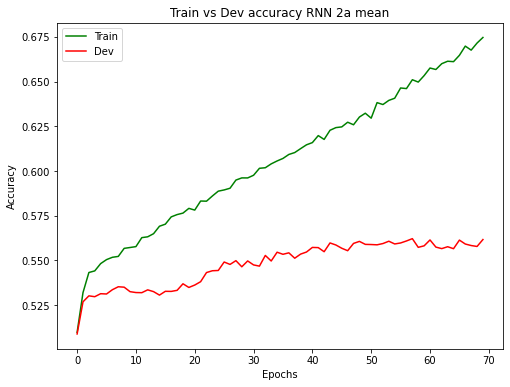

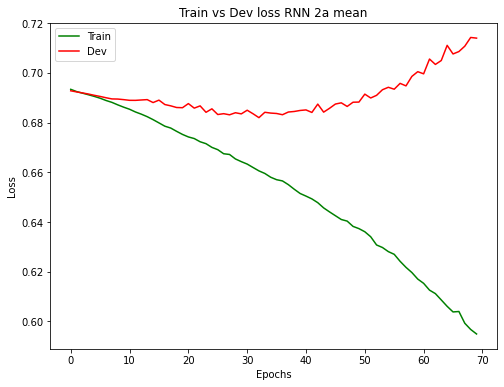

In [31]:
plot_mean_logs(mean_train_accuracy, mean_dev_accuracy, 'Train vs Dev accuracy RNN 2a mean', 'Accuracy')
plot_mean_logs(mean_train_loss, mean_dev_loss, 'Train vs Dev loss RNN 2a mean', 'Loss')